<a href="https://colab.research.google.com/github/zackives/upenn-cis-2450/blob/main/17_Module_3_Part_V_Neural_Nets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Networks

We'll see neural networks first in Scikit-learn and then in PyTorch.  In both cases we'll use the simple MNIST dataset of numeric digit images.

## Autograder setup

In [1]:
#PLEASE ENSURE YOUR PENN-ID IS ENTERED CORRECTLY. IF NOT, THE AUTOGRADER WON'T KNOW WHO
#TO ASSIGN POINTS TO YOU IN OUR BACKEND
STUDENT_ID = 99999999 # YOUR PENN-ID GOES HERE AS AN INTEGER##PLEASE ENSURE YOUR PENN-ID IS ENTERED CORRECTLY. IF NOT, THE AUTOGRADER WON'T KNOW WHO

In [2]:
%%writefile notebook-config.yaml

grader_api_url: 'https://23whrwph9h.execute-api.us-east-1.amazonaws.com/default/Grader23'
grader_api_key: 'flfkE736fA6Z8GxMDJe2q8Kfk8UDqjsG3GVqOFOa'

Writing notebook-config.yaml


In [3]:
%set_env HW_ID=cis2450_fall24_HW9

env: HW_ID=cis2450_fall24_HW9


In [4]:
!pip3 install penngrader-client

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 11.5 MB/s eta 0:00:00


In [5]:
import os
from penngrader.grader import *

grader = PennGrader('notebook-config.yaml', os.environ['HW_ID'], STUDENT_ID, STUDENT_ID)

PennGrader initialized with Student ID: 99999999

Make sure this correct or we will not be able to store your grade


## Scikit-Learn Basics

For Scikit, we can take our data, break into test and train splits, scale the data, and train.  This will use `MLPClassifier`, aka multi-layer perceptrons.

Iteration 1, loss = 0.32043346
Iteration 2, loss = 0.15355752
Iteration 3, loss = 0.11542871
Iteration 4, loss = 0.09324411
Iteration 5, loss = 0.07912576
Iteration 6, loss = 0.07138717
Iteration 7, loss = 0.06214091
Iteration 8, loss = 0.05551503
Iteration 9, loss = 0.05028847
Iteration 10, loss = 0.04586576


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Training set score: 0.986850
Test set score: 0.970700


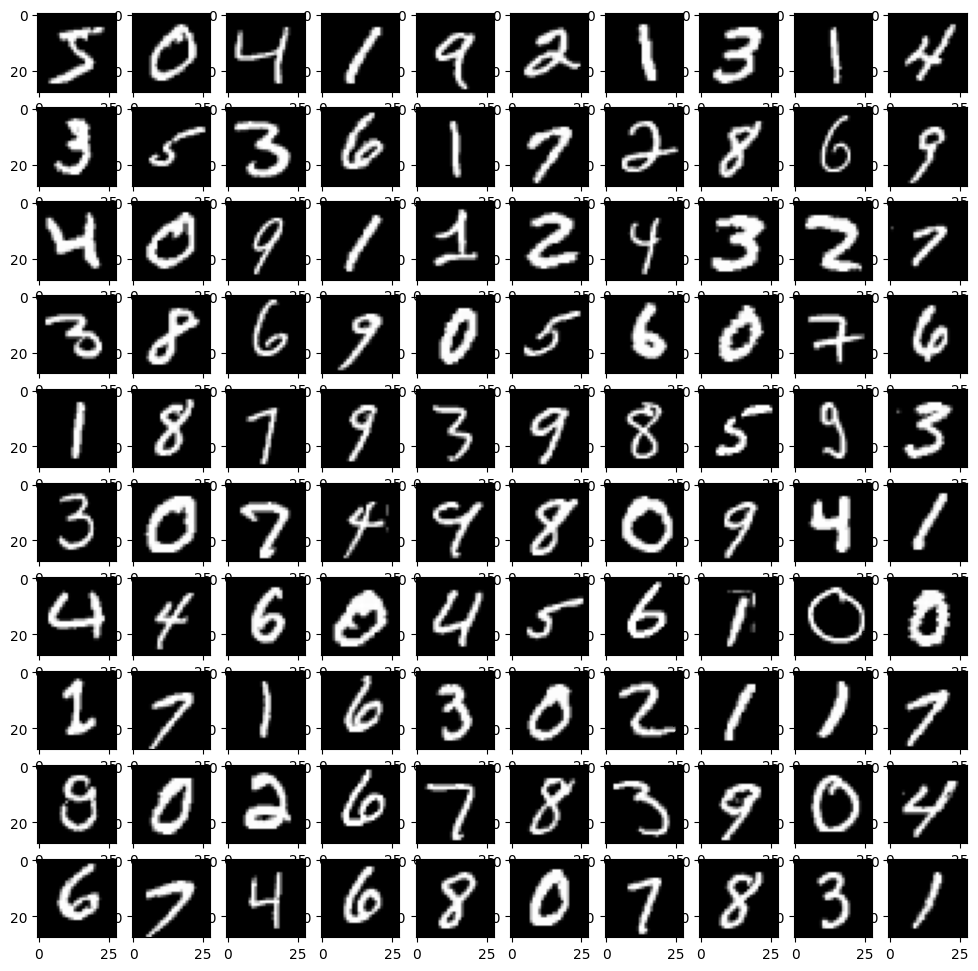

In [6]:
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler

# Load data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = MinMaxScaler().fit_transform(X)

plt.figure(figsize=(12, 12))

for img in range(100):
  ax = plt.subplot(10, 10, img+1)
  plt.imshow(X[img].reshape(28,28), cmap='gray')

# rescale the data, use the traditional train/test split
X_train, X_test = X[:60000], X[60000:]
y_train, y_test = y[:60000], y[60000:]

mlp = MLPClassifier(hidden_layer_sizes=(50,), \
                    max_iter=10, alpha=1e-4,
                    solver='sgd', verbose=10, random_state=1,
                    learning_rate_init=.1)

mlp.fit(X_train, y_train)
print("Training set score: %f" % mlp.score(X_train, y_train))
print("Test set score: %f" % mlp.score(X_test, y_test))

In [7]:
mlp.predict(X_test)

array(['7', '2', '1', ..., '4', '5', '6'], dtype='<U1')

## A PyTorch Implementation

This sample is based on https://colab.research.google.com/github/rpi-techfundamentals/fall2018-materials/blob/master/10-deep-learning/04-pytorch-mnist.ipynb#scrollTo=0VZWvo7vsxKM.

In [8]:
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

Let's set some of the training parameters.

In [9]:
args={
    'batch_size': 1000,
    'test_batch_size': 1000,
    'epochs': 25,    # Training epochs
    'lr': 0.005,      # Learning rate, sometimes called eta
    'momentum': 0.5, # SGD "momentum" -- moving average of gradients (helps to keep direction)
    'seed': 42,      # Random number seed
    'log_interval': 20, # How often to print log messages
    'cuda': True     # Use GPU
}
kwargs={}

For the data, we don't want to load it all at once. Instead we'll use the DataLoader to fetch batches of data and stream to the model.  The DataLoader can read images from files.

In [10]:
# Load MNIST in the data directory
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args['batch_size'], shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args['test_batch_size'], shuffle=True, **kwargs)


Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:02<00:00, 4.60MB/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 58.3kB/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.28MB/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 8.61MB/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



Now we have the basic NN, which is implemented as a `Module` in PyTorch.  The main things are to instantiate the stateful operators (in this case, anything with a weight), and then to establish how to compute the `forward` step.

Note that `forward` may include stateful operators, as well as stateless operators such as the activation functions and other items like dropout.

Dropout is used to regularize data during training -- in essence, certain activation units are randomly dropped with a certain probability.  As we do this, we temporarily scale up the other weights.

Later, during testing, all units are used (i.e., dropout is disabled) and the weights are scaled back to their original weights.

In [11]:
# This defines the structure of the NN

# We have initialization of the layers,
# followed by the feed-forward stage.
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Convolution first with 1 input and 10 output channels
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        # Convolution from 10 to 20
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        # We add a dropout stage to regularize the data
        self.conv2_drop = nn.Dropout2d()  #Dropout
        # Now we add the fully-connected stages
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        #Convolutional Layer/Pooling Layer/Activation
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        #Convolutional Layer/Dropout/Pooling Layer/Activation
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        # Change the shape, 320 wide, -1 is inferred based on the input
        # and other dimensions
        x = x.view(-1, 320)
        #Fully Connected Layer/Activation
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        #Fully Connected Layer/Activation
        x = self.fc2(x)
        #Softmax gets probabilities.
        return F.log_softmax(x, dim=1)


In [20]:

def train(epoch):
    model.train()

    # Iterate in mini-batch "chunks"
    for batch_idx, (data, target) in enumerate(train_loader):

        # If we are in cuda mode, we need to tell PyTorch to
        # copy the data into the GPU
        if args['cuda']:
            data, target = data.cuda(), target.cuda()
        #Variables in Pytorch are differenciable.
        data, target = Variable(data), Variable(target)
        #This will zero out the gradients for this batch.
        optimizer.zero_grad()

        # Feed-forward
        output = model(data)
        # Calculate the loss The negative log likelihood loss. It is useful to train a classification problem with C classes.
        loss = F.nll_loss(output, target)
        #dloss/dx for every Variable
        loss.backward()
        #to do a one-step update on our parameter.
        optimizer.step()
        #Print out the loss periodically.
        if batch_idx % args['log_interval'] == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))

def test():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if args['cuda']:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.nll_loss(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    return test_loss




In [13]:
model = Net()
if args['cuda']:
    model.cuda()
optimizer = optim.SGD(model.parameters(), lr=args['lr'], momentum=args['momentum'])

for epoch in range(1, args['epochs'] + 1):
        train(epoch)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.314307
Train Epoch: 1 [20000/60000 (33%)]	Loss: 2.301772
Train Epoch: 1 [40000/60000 (67%)]	Loss: 2.293492
Train Epoch: 2 [0/60000 (0%)]	Loss: 2.279689
Train Epoch: 2 [20000/60000 (33%)]	Loss: 2.270082
Train Epoch: 2 [40000/60000 (67%)]	Loss: 2.242166
Train Epoch: 3 [0/60000 (0%)]	Loss: 2.245519
Train Epoch: 3 [20000/60000 (33%)]	Loss: 2.196384
Train Epoch: 3 [40000/60000 (67%)]	Loss: 2.180105
Train Epoch: 4 [0/60000 (0%)]	Loss: 2.105804
Train Epoch: 4 [20000/60000 (33%)]	Loss: 2.023118
Train Epoch: 4 [40000/60000 (67%)]	Loss: 1.982311
Train Epoch: 5 [0/60000 (0%)]	Loss: 1.876479
Train Epoch: 5 [20000/60000 (33%)]	Loss: 1.772894
Train Epoch: 5 [40000/60000 (67%)]	Loss: 1.668413
Train Epoch: 6 [0/60000 (0%)]	Loss: 1.523695
Train Epoch: 6 [20000/60000 (33%)]	Loss: 1.387222
Train Epoch: 6 [40000/60000 (67%)]	Loss: 1.339074
Train Epoch: 7 [0/60000 (0%)]	Loss: 1.201656
Train Epoch: 7 [20000/60000 (33%)]	Loss: 1.207288
Train Epoch: 7 [40000/60000 (67%)]	

In [14]:
test()

<ipython-input-12-9266d977e774>:37: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data, target = Variable(data, volatile=True), Variable(target)
/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.1905, Accuracy: 9439/10000 (94%)



## Exercise

The code above uses the `SGD` optimizer to do its gradient descent.  This uses a fixed learning rate, which can cause it to under-or-overshoot.

An alternative is to use an *adaptive* optimizer, for instance the one called `Adam`.  In the codde below, create an instance of `optim.Adam` (arguments are similar to `SGD` except you should remove momentum).  See what happens if we run for 10 epochs.

In [17]:
args={
    'batch_size': 1000,
    'test_batch_size': 1000,
    'epochs': # TODO,     # Training epochs
    'lr': 0.005,      # Learning rate, sometimes called eta
    'momentum': 0.5, # SGD "momentum" -- moving average of gradients (helps to keep direction)
    'seed': 42,      # Random number seed
    'log_interval': 20, # How often to print log messages
    'cuda': True     # Use GPU
}
kwargs={}

In [18]:
model = Net()
if args['cuda']:
    model.cuda()
optimizer = # TODO

for epoch in range(1, args['epochs'] + 1):
  train(epoch)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.319777
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.717344
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.457617
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.356646
Train Epoch: 2 [20000/60000 (33%)]	Loss: 0.266996
Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.302241
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.275456
Train Epoch: 3 [20000/60000 (33%)]	Loss: 0.215599
Train Epoch: 3 [40000/60000 (67%)]	Loss: 0.238304
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.213119
Train Epoch: 4 [20000/60000 (33%)]	Loss: 0.218082
Train Epoch: 4 [40000/60000 (67%)]	Loss: 0.204349
Train Epoch: 5 [0/60000 (0%)]	Loss: 0.165453
Train Epoch: 5 [20000/60000 (33%)]	Loss: 0.173752
Train Epoch: 5 [40000/60000 (67%)]	Loss: 0.179243
Train Epoch: 6 [0/60000 (0%)]	Loss: 0.193233
Train Epoch: 6 [20000/60000 (33%)]	Loss: 0.183806
Train Epoch: 6 [40000/60000 (67%)]	Loss: 0.166926
Train Epoch: 7 [0/60000 (0%)]	Loss: 0.158246
Train Epoch: 7 [20000/60000 (33%)]	Loss: 0.155302
Train Epoch: 7 [40000/60000 (67%)]	

In [21]:
adam_loss = test()

<ipython-input-20-6bccbeabe39b>:37: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data, target = Variable(data, volatile=True), Variable(target)
/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.0421, Accuracy: 9870/10000 (99%)



In [23]:
grader.grade('adam_loss', adam_loss)

Correct! You earned 1/1 points. You are a star!

Your submission has been successfully recorded in the gradebook.
